# Bias detection and mitigation in AutoAI

This notebook contains the steps and code to demonstrate support of AutoAI experiments with bias detection/mitigation in Watson Machine Learning service. It introduces commands for data retrieval, training experiments, persisting pipelines, testing pipelines and scoring.

Some familiarity with Python is helpful. This notebook uses Python 3.11.


## Learning goals

The learning goals of this notebook are:

-  Work with Watson Machine Learning experiment to train AutoAI models with bias detection and mitigation.
-  Compare trained models quality and fairness.


## Contents

This notebook contains the following parts:

1. [Setup](#setup)
2. [Optimizer definition](#definition)
3. [Bias detection and mitigation](#run)
4. [Inspection of pipelines](#scoring)
5. [Cleanup](#cleanup)
6. [Summary and next steps](#summary)

<a id="setup"></a>
## 1. Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Contact with your Cloud Pack for Data administrator and ask him for your account credentials

### Install and import the `ibm-watsonx-ai` and dependecies
**Note:** `ibm-watsonx-ai` documentation can be found <a href="https://ibm.github.io/watsonx-ai-python-sdk/index.html" target="_blank" rel="noopener no referrer">here</a>.

In [ ]:
!pip install wget | tail -n 1
!pip install -U autoai-libs | tail -n 1
!pip install -U ibm-watsonx-ai | tail -n 1
!pip install scikit-learn==1.3.0 | tail -n 1
!pip install -U 'lale[fairness]>=0.8.2' | tail -n 1

### Connection to WML

Authenticate the Watson Machine Learning service on IBM Cloud Pack for Data. You need to provide platform `url`, your `username` and `api_key`.

In [1]:
username = 'PASTE YOUR USERNAME HERE'
api_key = 'PASTE YOUR API_KEY HERE'
url = 'PASTE THE PLATFORM URL HERE'

In [2]:
from ibm_watsonx_ai import Credentials

credentials = Credentials(
    username=username,
    api_key=api_key,
    url=url,
    instance_id="openshift",
    version="5.0"
)

Alternatively you can use `username` and `password` to authenticate WML services.

```python
credentials = Credentials(
    username=***,
    password=***,
    url=***,
    instance_id="openshift",
    version="5.0"
)

```

### Working with spaces

First of all, you need to create a space that will be used for your work. If you do not have space already created, you can use `{PLATFORM_URL}/ml-runtime/spaces?context=icp4data` to create one.

- Click New Deployment Space
- Create an empty space
- Go to space `Settings` tab
- Copy `space_id` and paste it below

**Tip**: You can also use SDK to prepare the space for your work. More information can be found [here](https://github.com/IBM/watson-machine-learning-samples/blob/master/cpd5.0/notebooks/python_sdk/instance-management/Space%20management.ipynb).

**Action**: Assign space ID below


In [3]:
from ibm_watsonx_ai import APIClient

client = APIClient(credentials)

In [4]:
space_id = 'PASTE YOUR SPACE ID HERE'

You can use `list` method to print all existing spaces.
```
client.spaces.list(limit=10)
```

In [5]:
client.set.default_space(space_id)

'SUCCESS'

<a id="definition"></a>
## Optimizer definition

### Training data sets

Define connection information to training data CSV file.

Download training data from git repository.

In [6]:
import wget
import os

filename = 'german_credit_data_biased_training.csv'

url = "https://github.com/IBM/watson-machine-learning-samples/raw/master/cpd5.0/data/bias/german_credit_data_biased_training.csv"
if not os.path.isfile(filename): 
    wget.download(url)

#### Create data asset

In [7]:
asset_details = client.data_assets.create('german_credit_data_biased_training.csv', filename)
asset_details

Creating data asset...
SUCCESS


{'metadata': {'space_id': 'e8402072-aee5-4fee-8e4f-836a1453ba6d',
  'usage': {'last_updated_at': '2024-05-21T11:25:11Z',
   'last_updater_id': '1000331001',
   'last_update_time': 1716290711056,
   'last_accessed_at': '2024-05-21T11:25:11Z',
   'last_access_time': 1716290711056,
   'last_accessor_id': '1000331001',
   'access_count': 0},
  'rov': {'mode': 0,
   'collaborator_ids': {},
   'member_roles': {'1000331001': {'user_iam_id': '1000331001',
     'roles': ['OWNER']}}},
  'name': 'german_credit_data_biased_training.csv',
  'description': '',
  'asset_type': 'data_asset',
  'origin_country': 'us',
  'resource_key': 'german_credit_data_biased_training.csv',
  'rating': 0.0,
  'total_ratings': 0,
  'catalog_id': '82c126ea-17a0-4742-a6cd-08c712cd5473',
  'created': 1716290711056,
  'created_at': '2024-05-21T11:25:11Z',
  'owner_id': '1000331001',
  'size': 0,
  'version': 2.0,
  'asset_state': 'available',
  'asset_attributes': ['data_asset'],
  'asset_id': 'e1c15f7e-c7c5-44b5-b5ef-89

In [8]:
client.data_assets.get_id(asset_details)

'e1c15f7e-c7c5-44b5-b5ef-89019f94e3f2'

In [9]:
from ibm_watsonx_ai.helpers import DataConnection

german_credit_risk = DataConnection(data_asset_id=client.data_assets.get_id(asset_details))

training_data_reference=[german_credit_risk]

### Bias detection and mitigation 

#### Terms and definitions:

`Fairness Attribute` - Bias or fairness is typically measured using some fairness attribute such as Gender, Ethnicity, Age, etc. 

`Monitored/Reference Group` - Monitored group are those values of fairness attribute for which we want to measure bias. The rest of the values of the fairness attributes are called as reference group. In case of Fairness Attribute=Gender, if we are trying to measure bias against females, then Monitored group is “Female” and Reference group is “Male”.

`Favourable/Unfavourable outcome` - An important concept in bias detection is that of favourable and unfavourable outcome of the model. E.g., Claim approved can be considered as a favourable outcome and Claim denied can be considered as an unfavourable outcome.

`Disparate Impact` - metric used to measure bias (computed as the ratio of percentage of favourable outcome for the monitored group to the percentage of favourable outcome for the reference group). Bias is said to exist if the disparate impact value is below some threshold.

#### Optimizer configuration

Provide input information for AutoAI optimizer:
- `name` - experiment name
- `prediction_type` - type of the problem
- `prediction_column` - target column name
- `fairness_info` - bias detection configuration
- `scoring` - `accuracy_and_disparate_impact` combined optimization metric for both accuracy and fairness. For  regression learning problem the `r2_and_disparate_impact` metric is supported (combines r2 and fairness).

#### `fairness_info` definition:

 - `protected_attributes` (list of dicts) – subset of features for which fairness calculation is desired.
     - `feature` - name of feature for which `reference_group` and `monitored_group` are specified.
     - `reference_group` and `monitored_group` - monitored group are those values of fairness attribute for which we want to measure bias. The rest of the values of the fairness attribute are reference group.
     
 - `favorable_labels` and `unfavorable_labels` – label values which are considered favorable (i.e. “positive”). `unfavorable_labels` are required when prediction type is regression.  
     
Examples of supported configuration:
```
fairness_info = {
            "protected_attributes": [
                {"feature": "Age", "reference_group": [[26, 26], [30, 75]], 
                                    "monitored_group": [[18, 25], [27, 29]]}
            ],
            "favorable_labels": ["No Risk"]
            }

```

```
fairness_info = {
            "protected_attributes": [
                {"feature": "sex", "reference_group": ['male', 'not specified'], 
                                   "monitored_group": ['female']},
                {"feature": "age", "reference_group": [[26, 100]], "monitored_group": [[18, 25], [27, 29]]}
            ],
            "favorable_labels": [[5000.01, 9000]],
            "unfavorable_labels": [[0, 5000], [9000, 1000000]]
            }

```

In [10]:
fairness_info = {
            "protected_attributes": [
                {"feature": "Sex", "reference_group": ['male'], "monitored_group": ['female']},
                {"feature": "Age", "reference_group": [[26, 75]], "monitored_group": [[18, 25]]}
            ],
            "favorable_labels": ["No Risk"],
            "unfavorable_labels": ["Risk"],
}

In [15]:
from ibm_watsonx_ai.experiment import AutoAI

experiment = AutoAI(credentials, space_id=space_id)

pipeline_optimizer = experiment.optimizer(
    name='Credit Risk Prediction and bias detection - AutoAI',
    prediction_type=AutoAI.PredictionType.BINARY,
    prediction_column='Risk',
    scoring='accuracy_and_disparate_impact',
    fairness_info=fairness_info,
    max_number_of_estimators = 1,
    retrain_on_holdout=False,
    include_only_estimators=["XGBClassifier"]
   )

<a id="run"></a>
## Experiment run

Call the `fit()` method to trigger the AutoAI experiment. You can either use interactive mode (synchronous job) or background mode (asychronous job) by specifying `background_model=True`.

In [16]:
run_details = pipeline_optimizer.fit(
            training_data_reference=training_data_reference,
            background_mode=False)

Training job aa651e79-447e-4199-bbed-588951d2f2a4 completed: 100%|████████| [02:04<00:00,  1.25s/it]


You can use the `get_run_status()` method to monitor AutoAI jobs in background mode.

### Get selected pipeline model

Download and reconstruct a scikit-learn pipeline model object from the
AutoAI training job.

In [17]:
experiment_summary = pipeline_optimizer.summary()
experiment_summary.head()

Enhancements  \
Pipeline Name                           
Pipeline_1                              
Pipeline_2                        HPO   
Pipeline_3                    HPO, FE   
Pipeline_4               HPO, FE, HPO   
Pipeline_5     HPO, FE, HPO, Ensemble   

                                                  Estimator  \
Pipeline Name                                                 
Pipeline_1                                    XGBClassifier   
Pipeline_2                                    XGBClassifier   
Pipeline_3                                    XGBClassifier   
Pipeline_4                                    XGBClassifier   
Pipeline_5     BatchedTreeEnsembleClassifier(XGBClassifier)   

               training_accuracy_and_disparate_impact_(optimized)  \
Pipeline Name                                                       
Pipeline_1                                              0.676887    
Pipeline_2                                              0.676887    
Pipeline_3                                              0.681126    
Pipeline_4                                              0.681126    
Pipeline_5                                              0.681126    

               training_disparate_impact_Sex  training_roc_auc  \
Pipeline Name                                                    
Pipeline_1                          1.009581          0.846120   
Pipeline_2                          1.009581          0.846120   
Pipeline_3                          1.009843          0.846576   
Pipeline_4                          1.009843          0.846576   
Pipeline_5                          1.009843          0.846576   

               holdout_disparate_impact_Sex  holdout_average_precision  \
Pipeline Name                                                            
Pipeline_1                         1.046499                   0.480936   
Pipeline_2                         1.046499                   0.480936   
Pipeline_3                         1.057825                   0.481095   
Pipeline_4                         1.057825                   0.481095   
Pipeline_5                         1.057825                   0.481095   

               holdout_log_loss  holdout_roc_auc  training_disparate_impact  \
Pipeline Name                                                                 
Pipeline_1             0.419151         0.855620                   1.825512   
Pipeline_2             0.419151         0.855620                   1.825512   
Pipeline_3             0.416944         0.855187                   1.787199   
Pipeline_4             0.416944         0.855187                   1.787199   
Pipeline_5             0.416944         0.855187                   1.787199   

               ...  holdout_accuracy  holdout_balanced_accuracy  \
Pipeline Name  ...                                                
Pipeline_1     ...          0.811623                   0.754275   
Pipeline_2     ...          0.811623                   0.754275   
Pipeline_3     ...          0.809619                   0.755745   
Pipeline_4     ...          0.809619                   0.755745   
Pipeline_5     ...          0.809619                   0.755745   

               training_recall  holdout_f1  training_accuracy  \
Pipeline Name                                                   
Pipeline_1            0.894970    0.867606           0.796567   
Pipeline_2            0.894970    0.867606           0.796567   
Pipeline_3            0.892283    0.865248           0.795004   
Pipeline_4            0.892283    0.865248           0.795004   
Pipeline_5            0.892283    0.865248           0.795004   

               holdout_disparate_impact  training_balanced_accuracy  \
Pipeline Name                                                         
Pipeline_1                     1.431694                    0.748223   
Pipeline_2                     1.431694                    0.748223   
Pipeline_3                     1.463687                    0.7472

### Visualize pipeline

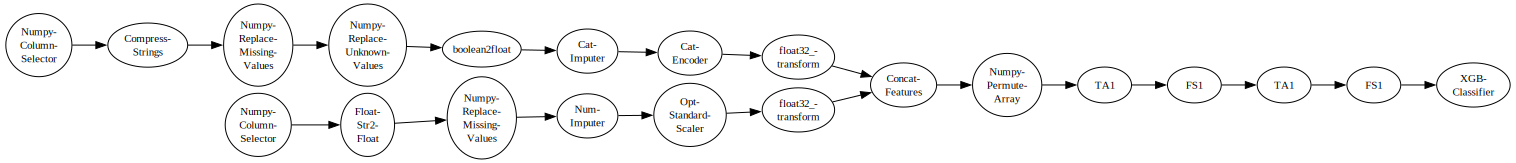

In [18]:
pipeline_name = experiment_summary.index[experiment_summary.holdout_disparate_impact.argmax()]
best_pipeline = pipeline_optimizer.get_pipeline(pipeline_name=pipeline_name)
best_pipeline.visualize()

Each node in the visualization is a machine-learning operator
(transformer or estimator). Each edge indicates data flow (transformed
output from one operator becomes input to the next).  The input to the
root nodes is the initial dataset and the output from the sink node
is the final prediction.  When you hover the mouse pointer over a
node, a tooltip shows you the configuration arguments of the
corresponding operator (tuned hyperparameters). When you click on the
hyperlink of a node, it brings you to a documentation page for the
operator.


<a id="scoring"></a>
### Test pipeline model locally

#### Read the data

In [ ]:
X_train, X_holdout, y_train, y_holdout = pipeline_optimizer.get_data_connections()[0].read(with_holdout_split=True)

#### Calculate metrics

For detail description of used metrics you can check the documentation:
- [accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) 
- [disparate_impact](https://lale.readthedocs.io/en/latest/modules/lale.lib.aif360.util.html#lale.lib.aif360.util.disparate_impact)

- [accuracy and disparate impact](https://lale.readthedocs.io/en/latest/modules/lale.lib.aif360.util.html#lale.lib.aif360.util.accuracy_and_disparate_impact)

In [20]:
from lale.lib.aif360 import disparate_impact, accuracy_and_disparate_impact
from sklearn.metrics import accuracy_score

predicted_y = best_pipeline.predict(X_holdout.values)
disparate_impact_scorer = disparate_impact(**fairness_info)
accuracy_disparate_impact_scorer = accuracy_and_disparate_impact(**fairness_info)

print("Accuracy: {:.2f}".format(accuracy_score(y_true= y_holdout, y_pred=predicted_y)))
print("Disparate impact: {:.2f}".format(disparate_impact_scorer(best_pipeline, X_holdout, y_holdout)))
print("Accuracy and disparate impact: {:.2f}".format(accuracy_disparate_impact_scorer(best_pipeline, X_holdout, y_holdout)))

Accuracy: 0.81
Disparate impact: 1.46
Accuracy and disparate impact: 0.75


---

## Fairness insights

You can analize favorable outcome distributions using `visualize` method from `utils` module.

In [21]:
from ibm_watsonx_ai.utils.autoai.fairness import visualize

visualize(run_details, pipeline_name)

---

<a id="cleanup"></a>
## Clean up

If you want to clean up all created assets:
- experiments
- trainings
- pipelines
- model definitions
- models
- functions
- deployments

please follow up this sample [notebook](https://github.com/IBM/watson-machine-learning-samples/blob/master/cpd5.0/notebooks/python_sdk/instance-management/Machine%20Learning%20artifacts%20management.ipynb).

<a id="summary"></a>
## Summary and next steps

You successfully completed this notebook!
 
As a next step you can deploy and score the model: [Sample notebook](https://github.com/IBM/watson-machine-learning-samples/blob/master/cpd5.0/notebooks/python_sdk/experiments/autoai/Use%20AutoAI%20and%20Lale%20to%20predict%20credit%20risk.ipynb).

Check out our _<a href="https://ibm.github.io/watsonx-ai-python-sdk/samples.html" target="_blank" rel="noopener no referrer">Online Documentation</a>_ for more samples, tutorials, documentation, how-tos, and blog posts. 
 
 

## Authors
**Lukasz Cmielowski, PhD**, is an Automation Architect and Data Scientist at IBM with a track record of developing enterprise-level applications that substantially increases clients' ability to turn data into actionable knowledge.

**Dorota Lączak**, software engineer in Watson Machine Learning at IBM

**Szymon Kucharczyk**, software engineer  in Watson Machine Learning at IBM

Copyright © 2021-2024 IBM. This notebook and its source code are released under the terms of the MIT License.